In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#change to your datapath
# %cd /content/drive/MyDrive/EAI_2023_fall/StudentID_lab3

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from resnet18 import *
from tqdm import tqdm   # for progress bar

In [4]:
# Create SummaryWriter
writer = SummaryWriter("./tensorboard")

In [5]:
#檢查是否可用gpu
print(torch.cuda.is_available())

True


In [6]:
# Get cpu, gpu or mps device for training.
# for mac m1, use mps
# for intel or amd cpu, use cpu
# for gpu, use cuda
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 256
lr = 0.05
# device = torch.device("cuda")

In [8]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std # in usual case, we don't have test dataset, we use train mean & std as test mean & std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified


Files already downloaded and verified
[0.49192894 0.4829865  0.4470311 ] [0.24717018 0.24370904 0.26192772]
[0.49192894 0.4829865  0.4470311 ] [0.24717018 0.24370904 0.26192772]


In [9]:
# data augmentation & normalization
transform_train = transforms.Compose([
    # data augmentation
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(train_mean, train_std)
])

# for test, we only need to normalize data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(train_mean, train_std)
])

In [10]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset長怎麼樣
print("trainset length: ", len(trainset))
print("classes: ", trainset.classes)
image, label = trainset[0]
print("image shape: ", image.shape)
print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
trainset length:  50000
classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
image shape:  torch.Size([3, 32, 32])
label:  6
train length:  45000
val length:  5000
test length:  10000


In [11]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler
    if epoch < 10:    # 0~9
        lr = 0.05
    elif epoch < 20:    # 10~19
        lr = 0.01
    elif epoch < 30:    # 20~29
        lr = 0.005
    else:               # 30~40
        lr = 0.001

    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [12]:
#是否pretrain
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in tqdm(range(pre_epoch, EPOCH)):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))

  0%|          | 0/40 [00:00<?, ?it/s]


Epoch: 1
learning rate:  0.05
Train loss: 1.519 | Train acc: 0.445


  2%|▎         | 1/40 [00:11<07:14, 11.13s/it]

Val loss: 1.369 | Val acc: 0.520

Epoch: 2
learning rate:  0.05
Train loss: 0.938 | Train acc: 0.667


  5%|▌         | 2/40 [00:21<06:38, 10.49s/it]

Val loss: 0.925 | Val acc: 0.676

Epoch: 3
learning rate:  0.05
Train loss: 0.676 | Train acc: 0.762


  8%|▊         | 3/40 [00:31<06:18, 10.24s/it]

Val loss: 0.864 | Val acc: 0.701

Epoch: 4
learning rate:  0.05
Train loss: 0.527 | Train acc: 0.815


 10%|█         | 4/40 [00:41<06:05, 10.16s/it]

Val loss: 0.930 | Val acc: 0.708

Epoch: 5
learning rate:  0.05
Train loss: 0.395 | Train acc: 0.862


 12%|█▎        | 5/40 [00:51<05:53, 10.09s/it]

Val loss: 0.681 | Val acc: 0.776

Epoch: 6
learning rate:  0.05
Train loss: 0.301 | Train acc: 0.895


 15%|█▌        | 6/40 [01:01<05:44, 10.12s/it]

Val loss: 0.666 | Val acc: 0.785

Epoch: 7
learning rate:  0.05
Train loss: 0.228 | Train acc: 0.919


 18%|█▊        | 7/40 [01:11<05:32, 10.07s/it]

Val loss: 0.850 | Val acc: 0.748

Epoch: 8
learning rate:  0.05
Train loss: 0.172 | Train acc: 0.940


 20%|██        | 8/40 [01:21<05:23, 10.11s/it]

Val loss: 0.817 | Val acc: 0.766

Epoch: 9
learning rate:  0.05
Train loss: 0.126 | Train acc: 0.956


 22%|██▎       | 9/40 [01:31<05:13, 10.10s/it]

Val loss: 0.861 | Val acc: 0.773

Epoch: 10
learning rate:  0.05
Train loss: 0.102 | Train acc: 0.965


 25%|██▌       | 10/40 [01:41<05:04, 10.14s/it]

Val loss: 0.759 | Val acc: 0.798

Epoch: 11
learning rate:  0.01
Train loss: 0.074 | Train acc: 0.975


 28%|██▊       | 11/40 [01:51<04:53, 10.11s/it]

Val loss: 0.935 | Val acc: 0.780

Epoch: 12
learning rate:  0.01
Train loss: 0.018 | Train acc: 0.996


 30%|███       | 12/40 [02:01<04:43, 10.11s/it]

Val loss: 0.586 | Val acc: 0.849

Epoch: 13
learning rate:  0.01
Train loss: 0.004 | Train acc: 1.000


 32%|███▎      | 13/40 [02:11<04:32, 10.09s/it]

Val loss: 0.581 | Val acc: 0.851

Epoch: 14
learning rate:  0.01
Train loss: 0.003 | Train acc: 1.000


 35%|███▌      | 14/40 [02:22<04:23, 10.12s/it]

Val loss: 0.584 | Val acc: 0.852

Epoch: 15
learning rate:  0.01
Train loss: 0.002 | Train acc: 1.000


 38%|███▊      | 15/40 [02:32<04:13, 10.12s/it]

Val loss: 0.584 | Val acc: 0.851

Epoch: 16
learning rate:  0.01
Train loss: 0.002 | Train acc: 1.000


 40%|████      | 16/40 [02:42<04:02, 10.12s/it]

Val loss: 0.584 | Val acc: 0.851

Epoch: 17
learning rate:  0.01
Train loss: 0.002 | Train acc: 1.000


 42%|████▎     | 17/40 [02:52<03:52, 10.10s/it]

Val loss: 0.581 | Val acc: 0.851

Epoch: 18
learning rate:  0.01
Train loss: 0.002 | Train acc: 1.000


 45%|████▌     | 18/40 [03:02<03:42, 10.11s/it]

Val loss: 0.582 | Val acc: 0.851

Epoch: 19
learning rate:  0.01
Train loss: 0.002 | Train acc: 1.000


 48%|████▊     | 19/40 [03:12<03:32, 10.10s/it]

Val loss: 0.581 | Val acc: 0.851

Epoch: 20
learning rate:  0.01
Train loss: 0.002 | Train acc: 1.000


 50%|█████     | 20/40 [03:22<03:22, 10.12s/it]

Val loss: 0.579 | Val acc: 0.850

Epoch: 21
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 52%|█████▎    | 21/40 [03:33<03:12, 10.14s/it]

Val loss: 0.576 | Val acc: 0.851

Epoch: 22
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 55%|█████▌    | 22/40 [03:43<03:02, 10.13s/it]

Val loss: 0.576 | Val acc: 0.851

Epoch: 23
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 57%|█████▊    | 23/40 [03:53<02:51, 10.11s/it]

Val loss: 0.576 | Val acc: 0.851

Epoch: 24
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 60%|██████    | 24/40 [04:03<02:41, 10.11s/it]

Val loss: 0.573 | Val acc: 0.851

Epoch: 25
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 62%|██████▎   | 25/40 [04:13<02:31, 10.11s/it]

Val loss: 0.575 | Val acc: 0.850

Epoch: 26
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 65%|██████▌   | 26/40 [04:23<02:21, 10.13s/it]

Val loss: 0.567 | Val acc: 0.852

Epoch: 27
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 68%|██████▊   | 27/40 [04:33<02:11, 10.15s/it]

Val loss: 0.572 | Val acc: 0.850

Epoch: 28
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 70%|███████   | 28/40 [04:43<02:01, 10.16s/it]

Val loss: 0.569 | Val acc: 0.852

Epoch: 29
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 72%|███████▎  | 29/40 [04:54<01:51, 10.15s/it]

Val loss: 0.568 | Val acc: 0.850

Epoch: 30
learning rate:  0.005
Train loss: 0.001 | Train acc: 1.000


 75%|███████▌  | 30/40 [05:04<01:41, 10.16s/it]

Val loss: 0.567 | Val acc: 0.849

Epoch: 31
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 78%|███████▊  | 31/40 [05:14<01:31, 10.17s/it]

Val loss: 0.565 | Val acc: 0.850

Epoch: 32
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 80%|████████  | 32/40 [05:24<01:21, 10.18s/it]

Val loss: 0.564 | Val acc: 0.852

Epoch: 33
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 82%|████████▎ | 33/40 [05:34<01:11, 10.19s/it]

Val loss: 0.567 | Val acc: 0.851

Epoch: 34
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 85%|████████▌ | 34/40 [05:45<01:01, 10.21s/it]

Val loss: 0.565 | Val acc: 0.849

Epoch: 35
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 88%|████████▊ | 35/40 [05:55<00:51, 10.23s/it]

Val loss: 0.565 | Val acc: 0.850

Epoch: 36
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 90%|█████████ | 36/40 [06:05<00:41, 10.26s/it]

Val loss: 0.566 | Val acc: 0.851

Epoch: 37
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 92%|█████████▎| 37/40 [06:15<00:30, 10.25s/it]

Val loss: 0.565 | Val acc: 0.849

Epoch: 38
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 95%|█████████▌| 38/40 [06:26<00:20, 10.27s/it]

Val loss: 0.565 | Val acc: 0.850

Epoch: 39
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


 98%|█████████▊| 39/40 [06:36<00:10, 10.27s/it]

Val loss: 0.564 | Val acc: 0.850

Epoch: 40
learning rate:  0.001
Train loss: 0.001 | Train acc: 1.000


100%|██████████| 40/40 [06:46<00:00, 10.17s/it]

Val loss: 0.562 | Val acc: 0.850


Test loss: 0.548 | Test acc: 0.856


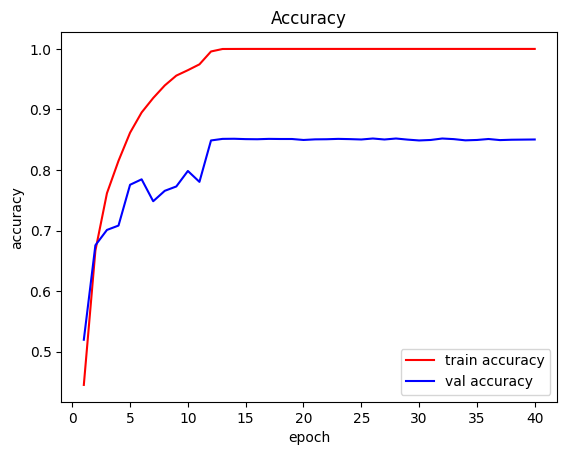

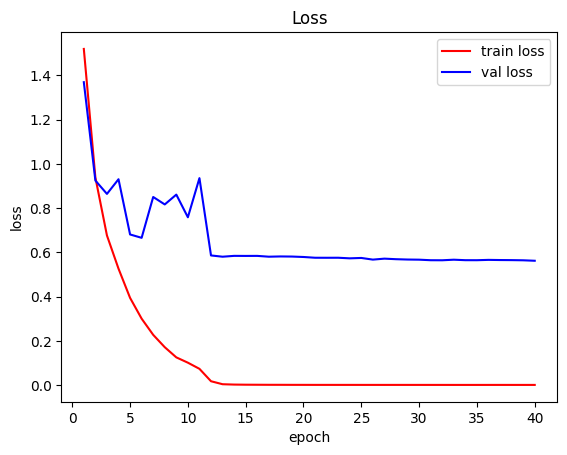

In [13]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()